# Hypergraph information

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations

sys.path.append("../src/")

import xgi
from reducibility_hg import *

from statannotations.Annotator import Annotator

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir  = f"{results_dir}synthetic/"

In [6]:
def optimization_rescaled(H, tau, rescaling_factors, rescale_per_node=False, sparse=False):

    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node, sparse=sparse
    )

    rho_all = density(L_multi, tau, sparse=sparse)

    D = []  # Learning error
    lZ = []  # Penalization term for model complexity

    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(
            H, orders[0 : l + 1], weights[0 : l + 1], rescale_per_node=rescale_per_node, sparse=sparse
        )
        rho_l = density(L_l, tau*rescaling_factors[l], sparse=sparse)
        d = KL(rho_all, rho_l, sparse=sparse)
        z = penalization(L_l, tau*rescaling_factors[l], sparse=sparse)

        D.append(d)
        lZ.append(z)

    lZ = np.array(lZ)
    D = np.array(D)

    return D, lZ

def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [np.pad(a, (0, max_shape-a.shape[0]), mode='constant', constant_values=None) for a in arr_list]
    return padded_arr_list

# Density - $\tau$ analysis, rescaling $\tau$

In [ ]:
rf_1 = 1
rf_2 = rf_1 + 2
rf_3 = rf_2 + 3
rf_4 = rf_3 + 4
inverse_rescaling_factors = np.array([1/rf_1, 1/rf_2, 1/rf_3, 1/rf_4]) * rf_4

### density = 5

In [21]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0,1,5):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        if p == 0:
            Hs_i.append(H0)
        else:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
            Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [22]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(H, tau_c, inverse_rescaling_factors, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [23]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:9.582e-01 t=5.252e-02
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.846e-08 t=5.895e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:7.316e-07 t=5.121e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.999e-06 t=4.903e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:7.466e-01 t=3.236e-01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.277e-10 t=-6.794e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:2.202e-08 t=5.833e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=-8.151e+15
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=2.095e+16
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=-3.157e+14


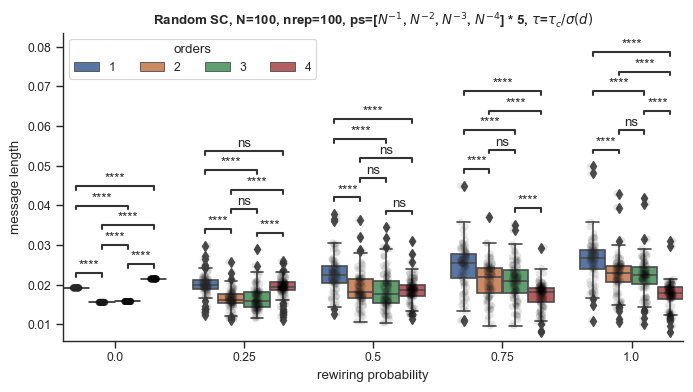

In [24]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$\tau_c/\sigma(d)$", weight="bold")


pairs = []
for p in np.linspace(0,1,5):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_0_25_50_75_100_s_5_char_tau_1_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [34]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0,1,5):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [36]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(H, 10*tau_c, inverse_rescaling_factors, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

In [37]:
for i, s in enumerate(np.linspace(0,1,5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:4.878e-35 t=1.666e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:5.024e-37 t=1.776e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.454e-10 t=6.625e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:2.572e-09 t=6.265e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:4.709e-07 t=5.220e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:4.533e-35 t=1.665e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.013e-12 t=7.638e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=7.213e+15
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=5.270e+15
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=1.326e+15
0.2

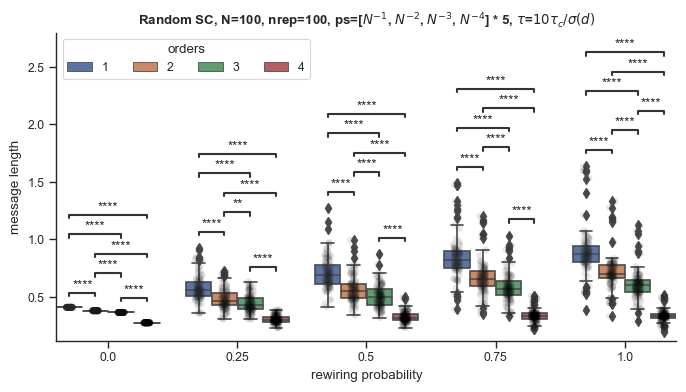

In [38]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$10\tau_c/\sigma(d)$", weight="bold")


pairs = []
for p in np.linspace(0,1,5):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_0_25_50_75_100_s_5_char_tau_10_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [39]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0,1,5):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [41]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(H, 30*tau_c, inverse_rescaling_factors, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

In [42]:
for i, s in enumerate(np.linspace(0,1,5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:9.349e-34 t=1.567e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.567e-34 t=1.614e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:8.534e-06 t=4.574e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:2.488e-04 t=3.732e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:2.752e-25 t=1.280e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:2.514e-39 t=1.764e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.962e-08 t=5.874e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=1.941e+16
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=1.225e+16
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=1.734e+16
0.2

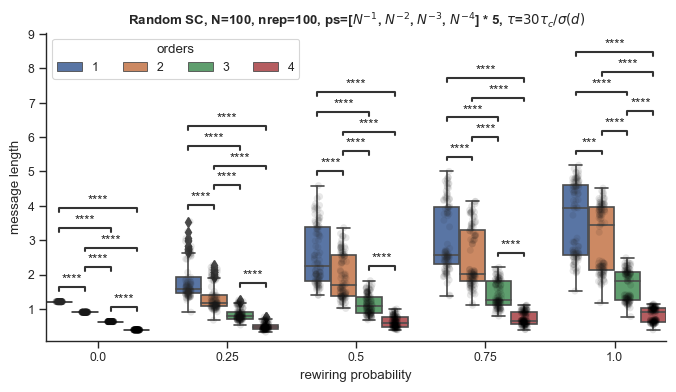

In [43]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$30\tau_c/\sigma(d)$", weight="bold")


pairs = []
for p in np.linspace(0,1,5):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_30_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [44]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0,1,5):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [46]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(H, 100*tau_c, inverse_rescaling_factors, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

In [47]:
for i, s in enumerate(np.linspace(0,1,5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:5.115e-43 t=2.109e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.874e-28 t=1.524e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.696e-03 t=3.193e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.515e-02 t=2.453e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:7.404e-18 t=1.042e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:2.206e-68 t=2.708e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.005e-12 t=7.863e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=inf
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=2.253e+16
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=inf
0.25_1 vs. 0.25

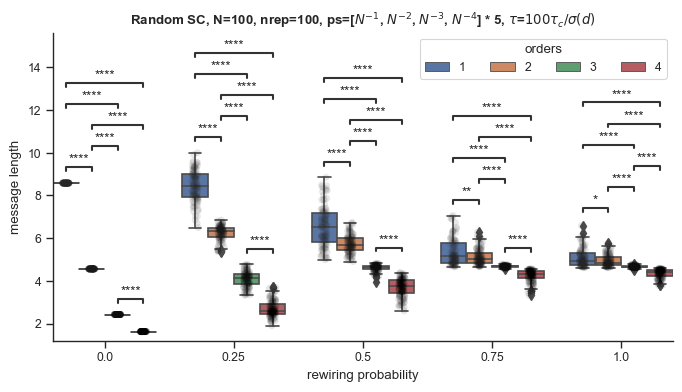

In [48]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$100\tau_c/\sigma(d)$", weight="bold")


pairs = []
for p in np.linspace(0,1,5):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_100_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

### density = 50

In [52]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [53]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [54]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.340e-06 t=-4.987e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:3.478e-03 t=-2.958e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.148e-01 t=1.584e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:7.327e-26 t=-1.232e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.217e-02 t=2.158e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:6.907e-48 t=-2.027e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:9.989e-10 t=6.422e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:9.144e-29 t=1.326e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.184e-05 t=4.259e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:4.755e-11 t=6.976

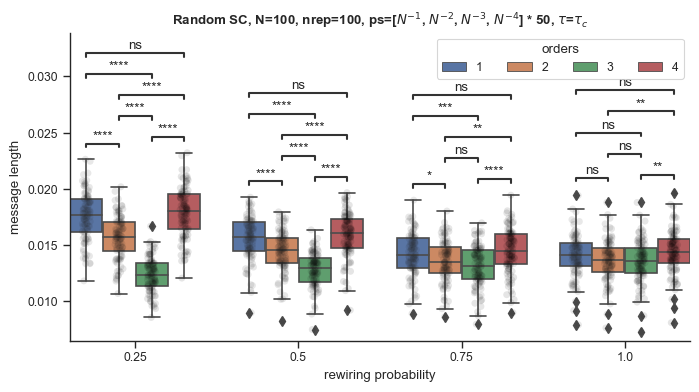

In [55]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_1_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [56]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [57]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 10*tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [58]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.555e-40 t=-1.880e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:9.031e-42 t=-1.965e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:6.078e-23 t=1.150e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:8.957e-39 t=-1.771e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:4.492e-22 t=1.117e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:4.903e-51 t=-2.240e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.009e-28 t=1.344e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.798e-12 t=7.526e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.010e-21 t=1.086e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:5.088e-06 t=4.690

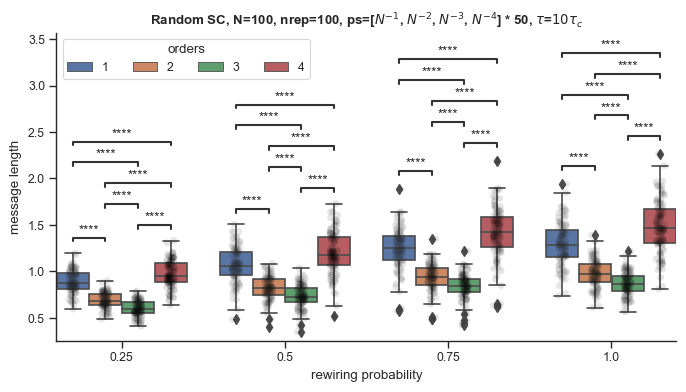

In [59]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$10\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_10_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [60]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [61]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 100*tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [62]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.229e-02 t=-2.165e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:8.555e-02 t=-1.734e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:9.129e-89 t=-7.450e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:3.416e-02 t=-2.137e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:2.403e-90 t=-7.733e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.001e-03 t=-3.010e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.427e-108 t=-1.184e+02
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:3.218e-21 t=-1.209e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.773e-99 t=-9.512e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:1.842e-14 t

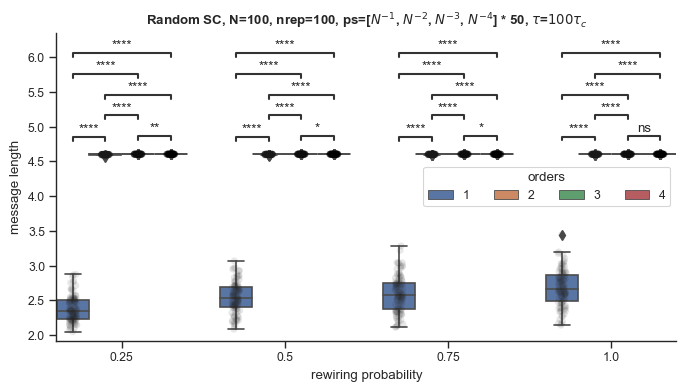

In [63]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$100\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_100_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [64]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [65]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 30*tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [67]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.111e-19 t=-1.041e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:2.145e-24 t=-1.269e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:5.927e-105 t=7.550e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.098e-19 t=-1.036e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.374e-106 t=7.480e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.367e-22 t=-1.107e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:2.087e-128 t=6.036e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.752e-79 t=-4.558e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.428e-130 t=7.460e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:8.575e-91 t=

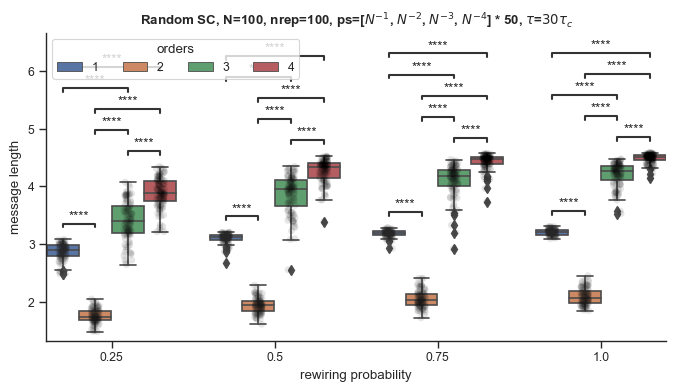

In [68]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$30\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_30_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

## density = 100

In [69]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [70]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [71]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:2.387e-21 t=-1.073e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:2.145e-12 t=-7.505e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:3.700e-04 t=3.623e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:5.336e-43 t=-1.820e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.446e-06 t=4.779e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.481e-64 t=-2.753e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.864e-18 t=9.720e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:5.245e-38 t=1.647e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.515e-11 t=7.020e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:5.864e-16 t=8.846

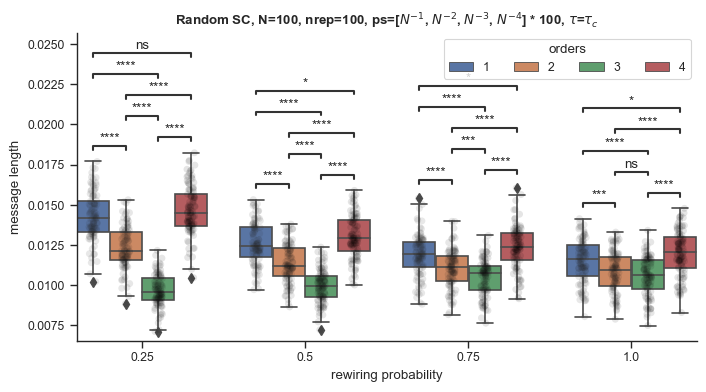

In [72]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_1_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [4]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [5]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 10*tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [6]:
def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [np.pad(a, (0, max_shape-a.shape[0]), mode='constant', constant_values=None) for a in arr_list]
    return padded_arr_list

for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:6.765e-68 t=-3.323e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:5.317e-75 t=-3.741e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.538e-50 t=2.208e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.929e-66 t=-3.233e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:4.715e-44 t=1.936e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.460e-67 t=-3.243e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.781e-43 t=1.906e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:6.845e-25 t=1.187e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:5.886e-43 t=1.892e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:4.054e-24 t=1.162

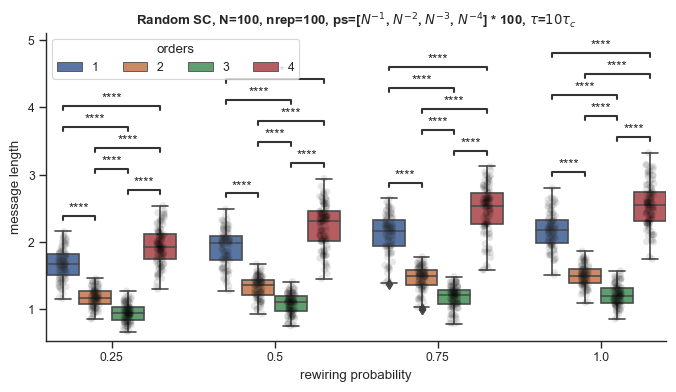

In [7]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$10\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_10_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [8]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [9]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 30*tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [10]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:2.159e-33 t=-1.807e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:1.464e-21 t=-1.223e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:8.266e-05 t=-4.075e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.112e-32 t=-1.766e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.615e-04 t=-3.895e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.736e-34 t=-1.819e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.601e-37 t=1.846e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:3.018e-102 t=-8.302e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:2.237e-11 t=7.369e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:3.165e-88 t=-

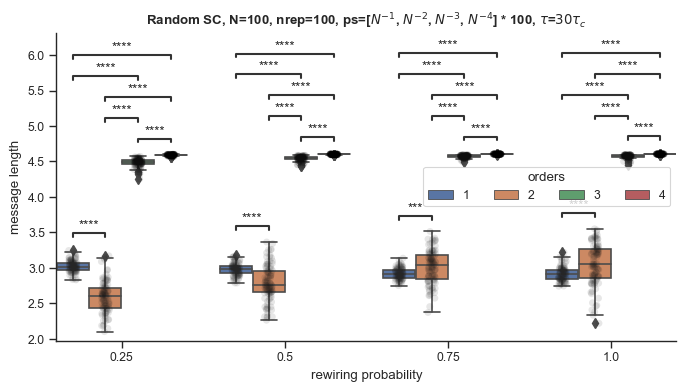

In [11]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$30\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_30_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [12]:
N = 100
ps = np.array([1/N, 1/N**2, 1/N**3, 1/N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25,1,4):
    Hs_i = []
    for rep in range(100): 
        if (rep+1)%100==0:
            print(rep+1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [13]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 100*tau_c, rescale_per_node=False)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p]= message_lengths_i                          

labels = [f"{i}" for i in np.linspace(0.25,1,4)]

In [14]:
for i, s in enumerate(np.linspace(0.25,1,4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:8.314e-02 t=-1.750e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:1.505e-05 t=-4.553e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.517e-74 t=-5.308e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:3.021e-01 t=-1.037e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:2.458e-74 t=-5.282e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.941e-16 t=-9.867e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:6.470e-87 t=-7.132e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:6.343e-24 t=-1.338e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:4.662e-77 t=-5.639e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:2.692e-09 t=

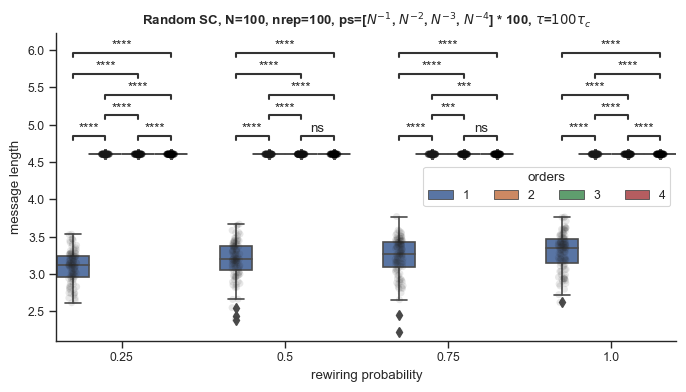

In [15]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$100\tau_c$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_100_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")